<a href="https://colab.research.google.com/github/shlee0619/Project_Disease/blob/main/0213%EC%BD%94%EB%A1%9C%EB%82%98(%EC%B5%9C%EC%A2%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
########################################
# 0. 환경 설정 및 라이브러리 설치 (Colab)
########################################
# Google Drive 연동 (Colab 환경인 경우)
from google.colab import drive
drive.mount('/content/gdrive')

# 필요한 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 keras-tcn xgboost

########################################
# 1. 라이브러리 Import 및 한글 폰트 설정
########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Statsmodels & Prophet
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# TensorFlow / Keras & TCN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tcn import TCN

# XGBoost
from xgboost import XGBRegressor

# Optuna
import optuna

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# 한글 폰트 설정 (Colab)
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 임포트 및 한글 폰트 설정 완료!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
라이브러리 임포트 및 한글 폰트 설정 완료!


In [3]:
########################################
# 2. 데이터 로드 및 전처리
########################################
def load_data(data_path):
    """
    여러 인코딩 방식으로 CSV 파일을 불러옵니다.
    """
    try:
        try:
            df_ = pd.read_csv(data_path, encoding='cp949')
        except UnicodeDecodeError:
            try:
                df_ = pd.read_csv(data_path, encoding='latin-1')
            except UnicodeDecodeError:
                df_ = pd.read_csv(data_path, encoding='cp1252')
        print("[INFO] 데이터 불러오기 성공!")
        return df_
    except FileNotFoundError:
        print(f"[ERROR] 파일을 찾을 수 없습니다. 경로: {data_path}")
    except Exception as e:
        print("[ERROR] 예기치 못한 에러 발생:", e)

DATA_PATH = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled_Plus_Traffic.csv'
df = load_data(DATA_PATH)

[INFO] 데이터 불러오기 성공!


In [6]:

# 원본 변수 목록
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)',' 평균최고기온(℃)','평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)','최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)','일사합(MJ/m2)','Traffic']

# Cases 차분 변수 추가
df['Cases_Diff'] = df['Cases'].diff(1)

# Date 컬럼 처리 및 정렬
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

In [7]:

# 간단 EDA 출력
print("\n데이터 예시(상위 5행):")
print(df.head())
print("\n데이터 info:")
print(df.info())
print("\n데이터 통계치:")
print(df.describe())


데이터 예시(상위 5행):
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최다일강수량(mm)  평균풍속(m/s)  최대풍속(m/s)  \
0  47.416719      2.2        7.8  ...         0.2        1.5       12.5   
1  52.897434      2.1        7.8  ...         0.7        1.3        9.5   
2  21.600817      1.3        5.7  ...         0.7        2.3       13.1   
3  18.842018      0.1        6.3  ...         2.0        1.8       13.4   
4  11.594881     -3.6        1.0  ...        26.0        3.0       14.7   

   최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  일사합(MJ/m2)  Traffic  Cases_Diff  
0      

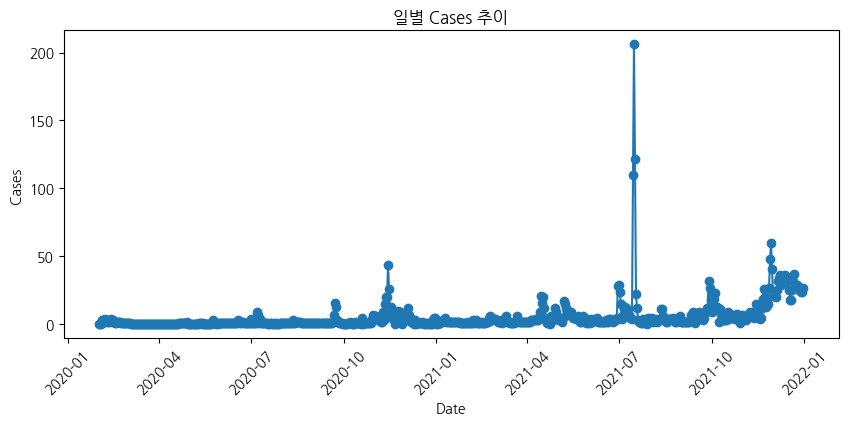

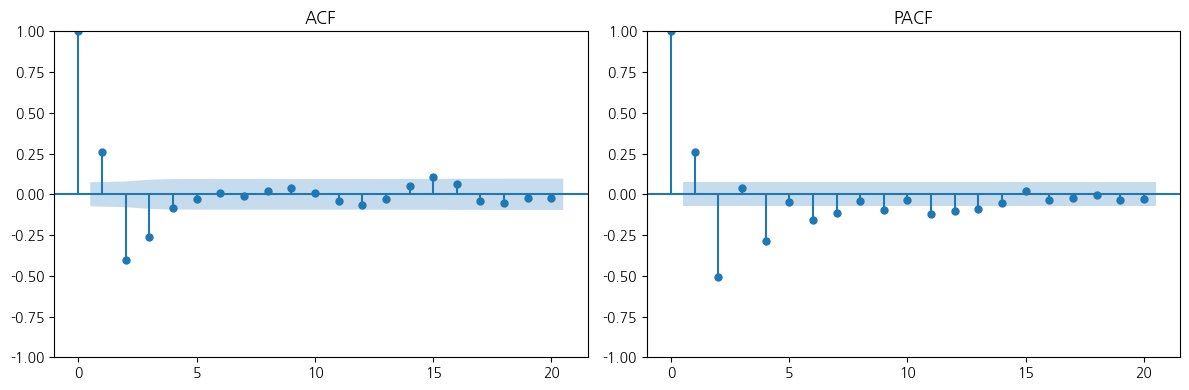

In [8]:
########################################
# 3. 간단 EDA (시각화)
########################################
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("일별 Cases 추이")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.show()

# ACF 및 PACF 플롯
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca())
plt.title("ACF")
plt.subplot(1,2,2)
plot_pacf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF")
plt.tight_layout()
plt.show()

In [9]:

########################################
# 4. Lag Feature 생성
########################################
def create_lag_features(dataframe, col_targets, lags):
    """
    col_targets에 대해 지정된 lags 만큼의 새로운 컬럼 생성.
    예: lags=(1,7,14) → 'col_target_lag1', 'col_target_lag7', 'col_target_lag14'
    """
    df_ = dataframe.copy()
    for col_target in col_targets:
        for lag in lags:
            df_[f"{col_target}_lag{lag}"] = df_[col_target].shift(lag)
    df_.dropna(inplace=True)
    return df_

df = create_lag_features(df, ['O3', 'PM25', '평균기온(℃)', '평균습도(%rh)','평균풍속(m/s)','Cases'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [10]:
import statsmodels.api as sm

# 종속변수: 'Cases'
y = df['Cases']

# 독립변수: 'Cases'와 'Date' 컬럼을 제외한 나머지 모든 컬럼
X = df.drop(['Cases', 'Date'], axis=1)

# 상수항 추가
X = sm.add_constant(X)

# OLS 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 결과 요약 출력 (계수, p-value, R-squared 등 확인 가능)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Cases   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.983e+20
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        00:34:45   Log-Likelihood:                 13226.
No. Observations:                 686   AIC:                        -2.624e+04
Df Residuals:                     579   BIC:                        -2.575e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.787e-10   1.85e-09     

In [23]:

# SARIMAX 튜닝 시 사용한 best feature (예시)
# feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10', 'PM25_lag13','평균풍속(m/s)_lag13','Traffic', 'Cases_lag1']
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)',' 평균최고기온(℃)',
            '평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)',
            '최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)',
            '일사합(MJ/m2)','Traffic']
feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10','최고기온(℃)', '평균풍속(m/s)','Traffic','Cases_lag1']

In [24]:

########################################
# 6. 시퀀스 데이터 생성 함수
########################################
def make_sequence_data(X_scaled, y_values, window):
    """
    window 길이만큼 슬라이딩 윈도우로 시퀀스 데이터를 생성합니다.
    X_seq: [샘플 수, window, feature 수]
    y_seq: window 이후의 target 값
    """
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - window):
        X_seq.append(X_scaled[i:i+window])
        y_seq.append(y_values[i+window])
    return np.array(X_seq), np.array(y_seq)

In [25]:
########################################
# 7. 모델 성능 평가 함수
########################################
def evaluate_performance(y_true, y_pred, model_name="Model"):
    mae_value = mean_absolute_error(y_true, y_pred)
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_value = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[{model_name}] MAE={mae_value:.3f}, RMSE={rmse_value:.3f}, MAPE={mape_value:.3f}")
    return {'model': model_name, 'MAE': mae_value, 'RMSE': rmse_value, 'MAPE': mape_value}

In [26]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 10) 테스트세트 크기: (153, 10)


In [27]:
########################################
# 6. 데이터 스케일링 (필요시)
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y도 스케일링 (딥러닝 모델에서 사용)
scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [48]:
########################################
# 8-1. SARIMAX (ARIMAX) 예시
########################################
feature_cols = ['SO2','CO','O3','NO2','O3_lag8','PM25','Traffic','Cases_lag1']
#feature_cols = ['SO2','CO','O3','NO2','O3_lag8','PM25','Traffic','Cases_lag1']
def train_sarimax(train_data, test_data, exog_cols, order=(1,0,1), seasonal_order=(0,0,1,7)):
    """
    SARIMAX(ARIMAX) 모델을 학습하고 예측값을 반환.
    order, seasonal_order는 필요에 따라 조정.
    """
    # train
    y_train_sar = train_data['Cases']
    X_train_sar = train_data[exog_cols]

    # test
    y_test_sar  = test_data['Cases']
    X_test_sar  = test_data[exog_cols]

    model = sm.tsa.statespace.SARIMAX(
        endog=y_train_sar,
        exog=X_train_sar,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    print("SARIMAX 학습 완료! summary:\n", result.summary())

    # 예측
    n_test = len(y_test_sar)
    forecast = result.predict(
        start=len(y_train_sar),
        end=len(y_train_sar)+n_test-1,
        exog=X_test_sar
    )
    return forecast


sarimax_pred = train_sarimax(train_df, test_df, exog_cols=feature_cols)
sarimax_result = evaluate_performance(y_test, sarimax_pred, model_name="SARIMAX")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

SARIMAX 학습 완료! summary:
                                      SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  533
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -1750.368
Date:                           Thu, 13 Feb 2025   AIC                           3524.736
Time:                                   00:48:03   BIC                           3575.874
Sample:                                        0   HQIC                          3544.762
                                           - 533                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SO2         1740.5430   1.98e-06   8.78e+08      0.000    1740.543    1740.543
CO           -10.6

In [108]:
########################################
# 5. Train/Validation/Test 분리 및 스케일링
########################################
feature_cols = ['SO2','CO','O3','NO2','O3','PM25','최고기온(℃)', '평균풍속(m/s)','Traffic','Cases_lag1']

# 날짜 기준 분할 (Validation < Test)
split_date_test = pd.to_datetime('2021-07-31')
split_date_val = pd.to_datetime('2021-05-31')

train_df = df[df['Date'] <= split_date_val].copy()
val_df = df[(df['Date'] > split_date_val) & (df['Date'] <= split_date_test)].copy()
test_df = df[df['Date'] > split_date_test].copy()
print(f"Train={train_df.shape}, Validation={val_df.shape}, Test={test_df.shape}")

# 타깃 변수 (Cases)
y_train = train_df['Cases']
y_val   = val_df['Cases']
y_test  = test_df['Cases']

# 독립변수 (Feature)
X_train = train_df[feature_cols].dropna()
X_val   = val_df[feature_cols].dropna()
X_test  = test_df[feature_cols].dropna()

# Feature 스케일링 (y는 스케일링하지 않음)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = y_train.values
y_val_scaled   = y_val.values
y_test_scaled  = y_test.values

Train=(472, 108), Validation=(61, 108), Test=(153, 108)


In [109]:
########################################
# 8. 모델 빌드 함수 (다층 구성 지원)
########################################
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(LSTM(lstm_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_gru_model(input_shape, gru_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(GRU(gru_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(GRU(gru_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_rnn_model(input_shape, rnn_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_cnn_model(input_shape, conv_filters, kernel_size, dropout_rate, optimizer_choice, learning_rate, num_layers=1):
    model = Sequential()
    # 첫 번째 Conv1D 레이어
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu',
                     input_shape=input_shape, padding='same'))
    # 추가 Conv1D 및 Dropout 레이어
    for i in range(1, num_layers):
        model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(Dropout(dropout_rate))
    # 시간 축을 1차원으로 flatten
    model.add(Flatten())
    # 최종 출력층
    model.add(Dense(1))

    # 옵티마이저 설정
    if optimizer_choice == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model


In [110]:

########################################
# 9. Optuna Objective Functions (Time Step 및 num_layers 튜닝)
########################################

In [111]:
def objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    lstm_units = trial.suggest_int("lstm_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10  # 빠른 튜닝을 위한 epoch 수 축소

    model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [112]:
def objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    gru_units = trial.suggest_int("gru_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [113]:
def objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    rnn_units = trial.suggest_int("rnn_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=rnn_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [114]:
def objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    conv_filters = trial.suggest_int('conv_filters', 16, 64, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer_choice = trial.suggest_categorical('optimizer_choice', ['adam', 'rmsprop', 'sgd'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 5

    model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=conv_filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        optimizer_choice=optimizer_choice,
        learning_rate=learning_rate,
        num_layers=num_layers
    )

    cv_mapes = []
    from sklearn.model_selection import TimeSeriesSplit
    tscv_ = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv_.split(X_train_seq):
        X_train_cv, X_val_cv = X_train_seq[train_idx], X_train_seq[val_idx]
        y_train_cv, y_val_cv = y_train_seq[train_idx], y_train_seq[val_idx]
        model_cv = clone_model(model)
        model_cv.set_weights(model.get_weights())
        model_cv.compile(optimizer=tf.keras.optimizers.get(optimizer_choice),
                           loss=tf.keras.losses.MeanAbsolutePercentageError(),
                           metrics=['mse', tf.keras.metrics.MeanAbsolutePercentageError()])
        hist = model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            shuffle=False
        )
        cv_mapes.append(hist.history['val_mean_absolute_percentage_error'][-1])
    return np.mean(cv_mapes)

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
# split_date = pd.to_datetime('2021-07-31')
# train_df = df[df['Date'] <= split_date].copy()
# test_df = df[df['Date'] > split_date].copy()

# print(f"Train={train_df.shape}, Test={test_df.shape}")

# X_train = train_df[feature_cols]
# y_train = train_df['Cases']
# X_test  = test_df[feature_cols]
# y_test  = test_df['Cases']

# # 결측 제거(Shift로 생긴 결측)
# X_train = X_train.dropna()
# y_train = y_train.loc[X_train.index]

# X_test = X_test.dropna()
# y_test = y_test.loc[X_test.index]

# print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(519, 108), Test=(153, 108)
최종 학습세트 크기: (519, 10) 테스트세트 크기: (153, 10)


In [115]:
########################################
# 10. Time Step 및 Hyperparameter 튜닝 실행 (Validation Set 사용)
########################################
timesteps_candidates = range(5, 15)
dl_results_timestep_tuning = []

for timesteps in timesteps_candidates:
    print(f"\n===== Time Steps: {timesteps} =====")

    # 데이터 준비: Feature/Target 분리 및 스케일링 (Validation set 포함)
    X_train_sub = train_df[feature_cols].dropna()
    X_val_sub   = val_df[feature_cols].dropna()
    X_test_sub  = test_df[feature_cols].dropna()

    X_train_scaled_sub = scaler_X.fit_transform(X_train_sub)
    X_val_scaled_sub   = scaler_X.transform(X_val_sub)
    X_test_scaled_sub  = scaler_X.transform(X_test_sub)

    # y index 정렬
    y_train_aligned = y_train.loc[X_train_sub.index]
    y_val_aligned   = y_val.loc[X_val_sub.index]
    y_test_aligned  = y_test.loc[X_test_sub.index]

    # 시퀀스 데이터 생성
    X_train_seq, y_train_seq = make_sequence_data(X_train_scaled_sub, y_train_aligned.values, window=timesteps)
    X_val_seq, y_val_seq     = make_sequence_data(X_val_scaled_sub, y_val_aligned.values, window=timesteps)
    X_test_seq, y_test_seq   = make_sequence_data(X_test_scaled_sub, y_test_scaled, window=timesteps)

    ########################################
    # LSTM 튜닝 및 평가
    ########################################
    study_lstm = optuna.create_study(direction='minimize')
    objective_lstm = lambda trial: objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_lstm.optimize(objective_lstm, n_trials=10)
    best_params_lstm = study_lstm.best_trial.params
    lstm_model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=best_params_lstm['lstm_units'],
        dropout_rate=best_params_lstm['dropout_rate'],
        learning_rate=best_params_lstm['learning_rate'],
        num_layers=best_params_lstm['num_layers']
    )
    epochs_best = 20
    lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                   epochs=epochs_best, batch_size=best_params_lstm['batch_size'], verbose=0)
    lstm_pred = lstm_model.predict(X_test_seq).flatten()
    lstm_result = evaluate_performance(y_test_seq, lstm_pred, model_name="LSTM")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'LSTM', 'Best Params': best_params_lstm, **lstm_result})

    ########################################
    # GRU 튜닝 및 평가
    ########################################
    study_gru = optuna.create_study(direction='minimize')
    objective_gru = lambda trial: objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_gru.optimize(objective_gru, n_trials=10)
    best_params_gru = study_gru.best_trial.params
    gru_model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=best_params_gru['gru_units'],
        dropout_rate=best_params_gru['dropout_rate'],
        learning_rate=best_params_gru['learning_rate'],
        num_layers=best_params_gru['num_layers']
    )
    gru_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_gru['batch_size'], verbose=0)
    gru_pred = gru_model.predict(X_test_seq).flatten()
    gru_result = evaluate_performance(y_test_seq, gru_pred, model_name="GRU")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'GRU', 'Best Params': best_params_gru, **gru_result})

    ########################################
    # RNN 튜닝 및 평가
    ########################################
    study_rnn = optuna.create_study(direction='minimize')
    objective_rnn = lambda trial: objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_rnn.optimize(objective_rnn, n_trials=10)
    best_params_rnn = study_rnn.best_trial.params
    rnn_model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=best_params_rnn['rnn_units'],
        dropout_rate=best_params_rnn['dropout_rate'],
        learning_rate=best_params_rnn['learning_rate'],
        num_layers=best_params_rnn['num_layers']
    )
    rnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_rnn['batch_size'], verbose=0)
    rnn_pred = rnn_model.predict(X_test_seq).flatten()
    rnn_result = evaluate_performance(y_test_seq, rnn_pred, model_name="RNN")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'RNN', 'Best Params': best_params_rnn, **rnn_result})

    ########################################
    # CNN 튜닝 및 평가
    ########################################
    study_cnn = optuna.create_study(direction='minimize')
    objective_cnn = lambda trial: objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_cnn.optimize(objective_cnn, n_trials=10)
    best_params_cnn = study_cnn.best_trial.params
    cnn_model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=best_params_cnn['conv_filters'],
        kernel_size=best_params_cnn['kernel_size'],
        dropout_rate=best_params_cnn['dropout_rate'],
        optimizer_choice=best_params_cnn['optimizer_choice'],
        learning_rate=best_params_cnn['learning_rate'],
        num_layers=best_params_cnn['num_layers']
    )
    cnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_cnn['batch_size'], verbose=0)
    cnn_pred = cnn_model.predict(X_test_seq).flatten()
    cnn_result = evaluate_performance(y_test_seq, cnn_pred, model_name="CNN")

    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'CNN', 'Best Params': best_params_cnn, **cnn_result})

[I 2025-02-13 02:01:41,296] A new study created in memory with name: no-name-b9c668fb-c1ff-4281-9100-9b350e63bfae



===== Time Steps: 5 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:01:52,641] Trial 0 finished with value: 88830.9921875 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0003652177584802335, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 88830.9921875.
[I 2025-02-13 02:02:06,092] Trial 1 finished with value: 6186.95263671875 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.00931743940637828, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 6186.95263671875.
[I 2025-02-13 02:02:25,367] Trial 2 finished with value: 4936.40185546875 and parameters: {'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001171444010509668, 'batch_size': 64, 'n

5/5 [==============================] - 2s 6ms/step


[I 2025-02-13 02:04:05,292] A new study created in memory with name: no-name-be912334-fbb2-48ab-bf8b-4deb6913cf3a


[LSTM] MAE=12.480, RMSE=16.969, MAPE=1.000


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:04:23,207] Trial 0 finished with value: 52812.6875 and parameters: {'gru_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.008824969158941277, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 52812.6875.
[I 2025-02-13 02:04:36,138] Trial 1 finished with value: 89632.5625 and parameters: {'gru_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.0010644738963628993, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 52812.6875.
[I 2025-02-13 02:04:52,497] Trial 2 finished with value: 1246.5203857421875 and parameters: {'gru_units': 224, 'dropout_rate': 0.2, 'learning_rate': 0.00018817608707426744, 'batch_size': 64, 'num_layers': 3}.

5/5 [==============================] - 1s 13ms/step


[I 2025-02-13 02:06:42,069] A new study created in memory with name: no-name-07826e95-af33-4501-a592-f0ebdfc0061c


[GRU] MAE=12.490, RMSE=16.975, MAPE=1.002


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:06:45,254] Trial 0 finished with value: 709136.3125 and parameters: {'rnn_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.0010223295250835777, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 709136.3125.
[I 2025-02-13 02:06:55,017] Trial 1 finished with value: 235579.140625 and parameters: {'rnn_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.002490938223127929, 'batch_size': 16, 'num_layers': 3}. Best is trial 1 with value: 235579.140625.
[I 2025-02-13 02:06:59,132] Trial 2 finished with value: 253901.984375 and parameters: {'rnn_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00010242279444652493, 'batch_size': 64,

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 02:07:37,333] A new study created in memory with name: no-name-61d3d516-949e-4e92-8e6c-36f70529d7a3


[RNN] MAE=12.478, RMSE=16.954, MAPE=1.002


[I 2025-02-13 02:07:42,168] Trial 0 finished with value: 469729430295893.3 and parameters: {'conv_filters': 32, 'kernel_size': 2, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.00038173927941143623, 'num_layers': 1}. Best is trial 0 with value: 469729430295893.3.
[I 2025-02-13 02:07:48,252] Trial 1 finished with value: 7388525.791666667 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.00046461884811388774, 'num_layers': 1}. Best is trial 1 with value: 7388525.791666667.
[I 2025-02-13 02:07:56,441] Trial 2 finished with value: 2777181.5416666665 and parameters: {'conv_filters': 64, 'kernel_size': 3, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.0005425571488163689, 'num_layers': 2}. Best is trial 2 with value: 2777181.5416666665.
[I 2025-02-13 02:08:03,119] Trial 3 finished with value: 8558690.75 and parameters: {'conv_

5/5 [==============================] - 0s 4ms/step


[I 2025-02-13 02:08:37,356] A new study created in memory with name: no-name-7a237de2-e3a4-4291-9089-573ea354b9dc


[CNN] MAE=12.477, RMSE=16.969, MAPE=0.999

===== Time Steps: 6 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:08:41,317] Trial 0 finished with value: 277663.40625 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0010575203476078992, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 277663.40625.
[I 2025-02-13 02:09:09,207] Trial 1 finished with value: 4068.848876953125 and parameters: {'lstm_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.00931185577617619, 'batch_size': 16, 'num_layers': 3}. Best is trial 1 with value: 4068.848876953125.
[I 2025-02-13 02:09:27,256] Trial 2 finished with value: 5041.33544921875 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.0015715773075272682, 'batch_size': 64, '

5/5 [==============================] - 2s 17ms/step


[I 2025-02-13 02:11:32,031] A new study created in memory with name: no-name-9da0676d-94f2-48f4-a162-7e9dd61dc8fa


[LSTM] MAE=12.545, RMSE=17.025, MAPE=1.000


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:11:45,137] Trial 0 finished with value: 5217.6328125 and parameters: {'gru_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0023488540101733175, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 5217.6328125.
[I 2025-02-13 02:12:01,266] Trial 1 finished with value: 19251.43359375 and parameters: {'gru_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.002072325452261435, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 5217.6328125.
[I 2025-02-13 02:12:30,989] Trial 2 finished with value: 86815.34375 and parameters: {'gru_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.00044670455795943573, 'batch_size': 16, 'num_layers': 3

5/5 [==============================] - 1s 4ms/step


[I 2025-02-13 02:14:36,737] A new study created in memory with name: no-name-9dac6cc6-ae72-41d8-93f4-24c5af5c53ab


[GRU] MAE=12.551, RMSE=17.029, MAPE=1.001


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:14:38,782] Trial 0 finished with value: 61471.4765625 and parameters: {'rnn_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.0005235815701603382, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 61471.4765625.
[I 2025-02-13 02:14:43,336] Trial 1 finished with value: 21661.986328125 and parameters: {'rnn_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0012583930140002305, 'batch_size': 64, 'num_layers': 1}. Best is trial 1 with value: 21661.986328125.
[I 2025-02-13 02:14:50,183] Trial 2 finished with value: 162957.515625 and parameters: {'rnn_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.00034909835447741, 'batch_size'

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 02:15:35,428] A new study created in memory with name: no-name-33c0961d-9dd9-41fe-bcde-cd628ec4651a


[RNN] MAE=12.475, RMSE=16.995, MAPE=0.985


[I 2025-02-13 02:15:39,010] Trial 0 finished with value: 1.8006999746041174e+16 and parameters: {'conv_filters': 16, 'kernel_size': 4, 'dropout_rate': 0.0, 'batch_size': 64, 'optimizer_choice': 'sgd', 'learning_rate': 0.0004185146615968585, 'num_layers': 1}. Best is trial 0 with value: 1.8006999746041174e+16.
[I 2025-02-13 02:15:45,924] Trial 1 finished with value: 831207.1927083334 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0028494229002516266, 'num_layers': 3}. Best is trial 1 with value: 831207.1927083334.
[I 2025-02-13 02:15:53,097] Trial 2 finished with value: 1841762.7916666667 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dropout_rate': 0.0, 'batch_size': 32, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0003608539124437813, 'num_layers': 2}. Best is trial 1 with value: 831207.1927083334.
[I 2025-02-13 02:15:59,689] Trial 3 finished with value: 1462266.8404947917 and p

5/5 [==============================] - 0s 4ms/step


[I 2025-02-13 02:16:37,214] A new study created in memory with name: no-name-dfe486af-907c-4579-ba67-d0c94529521b


[CNN] MAE=12.544, RMSE=17.024, MAPE=1.000

===== Time Steps: 7 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:17:06,884] Trial 0 finished with value: 23542.16015625 and parameters: {'lstm_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0038362120405471723, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 23542.16015625.
[I 2025-02-13 02:17:12,005] Trial 1 finished with value: 39176.19921875 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0007569531977262518, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 23542.16015625.
[I 2025-02-13 02:17:18,548] Trial 2 finished with value: 109834.734375 and parameters: {'lstm_units': 160, 'dropout_rate': 0.1, 'learning_rate': 0.00037896808194525834, 'batc

5/5 [==============================] - 2s 6ms/step


[I 2025-02-13 02:19:25,099] A new study created in memory with name: no-name-9dd936fa-a1f7-401d-a66e-bd5230c68db9


[LSTM] MAE=12.611, RMSE=17.083, MAPE=1.000


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:19:41,180] Trial 0 finished with value: 5894.29150390625 and parameters: {'gru_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.0005883273810000154, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 5894.29150390625.
[I 2025-02-13 02:19:52,070] Trial 1 finished with value: 58054.14453125 and parameters: {'gru_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0002185571723883857, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 5894.29150390625.
[I 2025-02-13 02:20:08,022] Trial 2 finished with value: 100702.1015625 and parameters: {'gru_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.00019351631803826656, 'batch_size': 64

5/5 [==============================] - 1s 10ms/step


[I 2025-02-13 02:21:32,040] A new study created in memory with name: no-name-865a037c-0628-4a3b-9739-d3ed9fe6822c


[GRU] MAE=12.599, RMSE=17.077, MAPE=0.997


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:21:36,148] Trial 0 finished with value: 1924969.375 and parameters: {'rnn_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.006920920802206397, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 1924969.375.
[I 2025-02-13 02:21:42,422] Trial 1 finished with value: 5701529.0 and parameters: {'rnn_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.0007648375242491501, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 1924969.375.
[I 2025-02-13 02:21:48,316] Trial 2 finished with value: 2055342.875 and parameters: {'rnn_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.00980619797329673, 'batch_size': 64, 'num_layers': 3}. Best is 

5/5 [==============================] - 1s 6ms/step


[I 2025-02-13 02:22:38,109] A new study created in memory with name: no-name-cba84a1f-6e3b-4329-8cfb-caa4181825cf


[RNN] MAE=12.601, RMSE=17.132, MAPE=0.987


[I 2025-02-13 02:22:42,392] Trial 0 finished with value: 347579115459925.3 and parameters: {'conv_filters': 32, 'kernel_size': 4, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.00018404918898665403, 'num_layers': 1}. Best is trial 0 with value: 347579115459925.3.
[I 2025-02-13 02:22:46,922] Trial 1 finished with value: 2229847.4010416665 and parameters: {'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0012916806748934182, 'num_layers': 2}. Best is trial 1 with value: 2229847.4010416665.
[I 2025-02-13 02:22:52,072] Trial 2 finished with value: 10883680.166666666 and parameters: {'conv_filters': 32, 'kernel_size': 4, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.00032605275373195355, 'num_layers': 1}. Best is trial 1 with value: 2229847.4010416665.
[I 2025-02-13 02:22:57,637] Trial 3 finished with value: 4148118.9166666665 and parame

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 02:23:30,541] A new study created in memory with name: no-name-dcde0e1c-3939-47f3-8b63-d884e64c40f2


[CNN] MAE=12.611, RMSE=17.085, MAPE=1.000

===== Time Steps: 8 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:23:43,965] Trial 0 finished with value: 42676.703125 and parameters: {'lstm_units': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00041510326016665027, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 42676.703125.
[I 2025-02-13 02:24:03,489] Trial 1 finished with value: 15166.478515625 and parameters: {'lstm_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.00011751382884295954, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 15166.478515625.
[I 2025-02-13 02:24:10,893] Trial 2 finished with value: 43445.18359375 and parameters: {'lstm_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.0016231504071729994, 'batch

5/5 [==============================] - 1s 16ms/step


[I 2025-02-13 02:25:48,728] A new study created in memory with name: no-name-4971d72a-a097-43e9-9c12-4ae0c1709143


[LSTM] MAE=12.679, RMSE=17.128, MAPE=1.001


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:26:03,719] Trial 0 finished with value: 21039.37890625 and parameters: {'gru_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.0024358870814939274, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 21039.37890625.
[I 2025-02-13 02:26:19,654] Trial 1 finished with value: 351088.0 and parameters: {'gru_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.000451544558938039, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 21039.37890625.
[I 2025-02-13 02:26:29,756] Trial 2 finished with value: 166196.671875 and parameters: {'gru_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0003553845497093813, 'batch_size': 64,

5/5 [==============================] - 0s 5ms/step


[I 2025-02-13 02:28:09,546] A new study created in memory with name: no-name-d5e8c3c8-aedc-445c-9443-a2cc65e97ca3


[GRU] MAE=12.706, RMSE=17.152, MAPE=1.005


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:28:13,835] Trial 0 finished with value: 359884.78125 and parameters: {'rnn_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.00014025607476168993, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 359884.78125.
[I 2025-02-13 02:28:18,562] Trial 1 finished with value: 429969.84375 and parameters: {'rnn_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0007716941474708875, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 359884.78125.
[I 2025-02-13 02:28:25,924] Trial 2 finished with value: 665070.9375 and parameters: {'rnn_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0006428768623024385, '

5/5 [==============================] - 0s 4ms/step


[I 2025-02-13 02:29:16,594] A new study created in memory with name: no-name-a44f420e-7abb-4941-86f9-3d1cda947276


[RNN] MAE=12.604, RMSE=17.098, MAPE=0.985


[I 2025-02-13 02:29:25,834] Trial 0 finished with value: 925623.1731770834 and parameters: {'conv_filters': 64, 'kernel_size': 2, 'dropout_rate': 0.4, 'batch_size': 32, 'optimizer_choice': 'adam', 'learning_rate': 0.008404535848129186, 'num_layers': 3}. Best is trial 0 with value: 925623.1731770834.
[I 2025-02-13 02:29:30,799] Trial 1 finished with value: 2914824.125 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.0, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.00022246843532249967, 'num_layers': 2}. Best is trial 0 with value: 925623.1731770834.
[I 2025-02-13 02:29:34,891] Trial 2 finished with value: 11386808.90625 and parameters: {'conv_filters': 32, 'kernel_size': 4, 'dropout_rate': 0.0, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.00905073633720185, 'num_layers': 1}. Best is trial 0 with value: 925623.1731770834.
[I 2025-02-13 02:29:40,796] Trial 3 finished with value: 2022948.4557291667 and parameters: {'conv_

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 02:30:22,435] A new study created in memory with name: no-name-b0fc7e05-f58c-471c-a936-36cb025a1e06


[CNN] MAE=12.682, RMSE=17.139, MAPE=1.000

===== Time Steps: 9 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:30:45,861] Trial 0 finished with value: 44439.05859375 and parameters: {'lstm_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0017840237432385716, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 44439.05859375.
[I 2025-02-13 02:30:56,637] Trial 1 finished with value: 18115.890625 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.004735220419167463, 'batch_size': 64, 'num_layers': 2}. Best is trial 1 with value: 18115.890625.
[I 2025-02-13 02:31:16,176] Trial 2 finished with value: 120187.171875 and parameters: {'lstm_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.006451133332418824, 'batch_size

5/5 [==============================] - 4s 14ms/step


[I 2025-02-13 02:33:45,581] A new study created in memory with name: no-name-79c9ed01-cd25-4044-a766-796f140ea5c3


[LSTM] MAE=12.749, RMSE=17.200, MAPE=1.001


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:33:51,399] Trial 0 finished with value: 17022.919921875 and parameters: {'gru_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.002131268800834831, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 17022.919921875.
[I 2025-02-13 02:33:59,634] Trial 1 finished with value: 30327.21484375 and parameters: {'gru_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0004912522513561614, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 17022.919921875.
[I 2025-02-13 02:34:11,477] Trial 2 finished with value: 711833.3125 and parameters: {'gru_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.00014420605463980326, 'batch_size': 64, 'num_la

5/5 [==============================] - 2s 36ms/step


[I 2025-02-13 02:37:06,062] A new study created in memory with name: no-name-e2dd1320-3e97-4784-9806-fefd1a28dc95


[GRU] MAE=12.746, RMSE=17.199, MAPE=1.000


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:37:09,388] Trial 0 finished with value: 540364.4375 and parameters: {'rnn_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.0008050638560181208, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 540364.4375.
[I 2025-02-13 02:37:12,281] Trial 1 finished with value: 506914.3125 and parameters: {'rnn_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.0032181728276322536, 'batch_size': 16, 'num_layers': 1}. Best is trial 1 with value: 506914.3125.
[I 2025-02-13 02:37:21,257] Trial 2 finished with value: 7299344.0 and parameters: {'rnn_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.001461538679851451, 'batch_size': 64, 'num_layers': 3}. Best 

5/5 [==============================] - 0s 4ms/step


[I 2025-02-13 02:38:06,090] A new study created in memory with name: no-name-24dd51a7-2343-4d5a-a856-10ced375522b


[RNN] MAE=12.706, RMSE=17.165, MAPE=0.994


[I 2025-02-13 02:38:12,308] Trial 0 finished with value: 1816392.0625 and parameters: {'conv_filters': 48, 'kernel_size': 5, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.00022851052973977886, 'num_layers': 2}. Best is trial 0 with value: 1816392.0625.
[I 2025-02-13 02:38:19,693] Trial 1 finished with value: 1113112.3017578125 and parameters: {'conv_filters': 16, 'kernel_size': 5, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.0011011273065280936, 'num_layers': 3}. Best is trial 1 with value: 1113112.3017578125.
[I 2025-02-13 02:38:23,527] Trial 2 finished with value: 6031083.130208333 and parameters: {'conv_filters': 48, 'kernel_size': 5, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0003953704302393911, 'num_layers': 1}. Best is trial 1 with value: 1113112.3017578125.
[I 2025-02-13 02:38:28,565] Trial 3 finished with value: 14125029.583333334 and p

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 02:39:02,777] A new study created in memory with name: no-name-2df9e37f-4eb8-4258-bfd2-03326e3bf581


[CNN] MAE=12.742, RMSE=17.193, MAPE=1.000

===== Time Steps: 10 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:39:16,148] Trial 0 finished with value: 37285.84765625 and parameters: {'lstm_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0001361410243063422, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 37285.84765625.
[I 2025-02-13 02:39:29,419] Trial 1 finished with value: 44384.1328125 and parameters: {'lstm_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.0006507468335354106, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 37285.84765625.
[I 2025-02-13 02:39:48,110] Trial 2 finished with value: 9514.0732421875 and parameters: {'lstm_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00025688954769733665, 'ba

5/5 [==============================] - 2s 51ms/step


[I 2025-02-13 02:42:31,556] A new study created in memory with name: no-name-2d3edf13-f368-481e-a85e-6ec3a96b78f6


[LSTM] MAE=12.804, RMSE=17.252, MAPE=1.000


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:42:58,215] Trial 0 finished with value: 261951.75 and parameters: {'gru_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.0005944641181678319, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 261951.75.
[I 2025-02-13 02:43:06,467] Trial 1 finished with value: 211953.796875 and parameters: {'gru_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.0004116438230182653, 'batch_size': 32, 'num_layers': 1}. Best is trial 1 with value: 211953.796875.
[I 2025-02-13 02:43:14,665] Trial 2 finished with value: 428798.8125 and parameters: {'gru_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0016287565884575608, 'batch_size': 64, 'num_layers': 2}. Best

5/5 [==============================] - 1s 12ms/step


[I 2025-02-13 02:45:21,528] A new study created in memory with name: no-name-732eb85e-b338-4851-ad25-ba4d76526b00


[GRU] MAE=12.813, RMSE=17.258, MAPE=1.002


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:45:27,877] Trial 0 finished with value: 1697992.625 and parameters: {'rnn_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0006014934889939887, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 1697992.625.
[I 2025-02-13 02:45:37,772] Trial 1 finished with value: 1328582.875 and parameters: {'rnn_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.002956629669031448, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 1328582.875.
[I 2025-02-13 02:45:46,926] Trial 2 finished with value: 2741118.0 and parameters: {'rnn_units': 160, 'dropout_rate': 0.5, 'learning_rate': 0.003214228779504081, 'batch_size': 64, 'num_layers': 3}. Best is

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 02:46:20,915] A new study created in memory with name: no-name-dcb02175-0b4f-4916-a780-eeb671c8d7af


[RNN] MAE=12.801, RMSE=17.263, MAPE=0.997


[I 2025-02-13 02:46:24,381] Trial 0 finished with value: 184785275416576.0 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.005384031734230859, 'num_layers': 1}. Best is trial 0 with value: 184785275416576.0.
[I 2025-02-13 02:46:29,412] Trial 1 finished with value: 10791151.791666666 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.0004973711599846983, 'num_layers': 1}. Best is trial 1 with value: 10791151.791666666.
[I 2025-02-13 02:46:36,523] Trial 2 finished with value: 5996255.625 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.00011058930902041585, 'num_layers': 1}. Best is trial 2 with value: 5996255.625.
[W 2025-02-13 02:46:44,267] Trial 3 failed with parameters: {'conv_filters': 16, 'kernel_size': 2, 'dropo

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 02:47:21,573] A new study created in memory with name: no-name-4be6fcf8-ef6a-4b54-955b-934f40d6f641


[CNN] MAE=12.803, RMSE=17.251, MAPE=1.000

===== Time Steps: 11 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:47:33,927] Trial 0 finished with value: 36986.94921875 and parameters: {'lstm_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.004480492685353636, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 36986.94921875.
[I 2025-02-13 02:47:40,476] Trial 1 finished with value: 43009.55078125 and parameters: {'lstm_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.005013920479157937, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 36986.94921875.
[I 2025-02-13 02:47:51,279] Trial 2 finished with value: 975710.8125 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0001301980580790

5/5 [==============================] - 1s 7ms/step


[I 2025-02-13 02:50:17,659] A new study created in memory with name: no-name-034ce669-ea1b-404a-9ad3-e97700261bff


[LSTM] MAE=12.861, RMSE=17.309, MAPE=0.996


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:50:38,134] Trial 0 finished with value: 18694.849609375 and parameters: {'gru_units': 160, 'dropout_rate': 0.1, 'learning_rate': 0.0009984483761890988, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 18694.849609375.
[I 2025-02-13 02:50:46,501] Trial 1 finished with value: 415013.3125 and parameters: {'gru_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.0009411406492520294, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 18694.849609375.
[I 2025-02-13 02:50:55,966] Trial 2 finished with value: 787409.125 and parameters: {'gru_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.002002122782003577, 'batch_size': 16, 'num_layers

5/5 [==============================] - 2s 20ms/step


[I 2025-02-13 02:52:58,993] A new study created in memory with name: no-name-35f99414-5122-4cde-b2fa-019968715cb2


[GRU] MAE=12.853, RMSE=17.296, MAPE=0.996


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:53:03,956] Trial 0 finished with value: 659759.8125 and parameters: {'rnn_units': 256, 'dropout_rate': 0.1, 'learning_rate': 0.000507695807419762, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 659759.8125.
[I 2025-02-13 02:53:09,333] Trial 1 finished with value: 417678.625 and parameters: {'rnn_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0017361386222111998, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 417678.625.
[I 2025-02-13 02:53:17,773] Trial 2 finished with value: 187097.078125 and parameters: {'rnn_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.004900003817792222, 'batch_size': 64, 'num_la

5/5 [==============================] - 0s 10ms/step


[I 2025-02-13 02:54:13,328] A new study created in memory with name: no-name-bed3e42d-4694-4ed3-b76f-8d2a52f8f276


[RNN] MAE=12.785, RMSE=17.245, MAPE=0.984


[I 2025-02-13 02:54:20,999] Trial 0 finished with value: 6342599.395833333 and parameters: {'conv_filters': 32, 'kernel_size': 2, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.005402324296505832, 'num_layers': 3}. Best is trial 0 with value: 6342599.395833333.
[I 2025-02-13 02:54:24,598] Trial 1 finished with value: 222825486308693.34 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.005931972739468632, 'num_layers': 1}. Best is trial 0 with value: 6342599.395833333.
[I 2025-02-13 02:54:33,994] Trial 2 finished with value: 5229058.020833333 and parameters: {'conv_filters': 48, 'kernel_size': 4, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.00456295717854417, 'num_layers': 1}. Best is trial 2 with value: 5229058.020833333.
[I 2025-02-13 02:54:40,563] Trial 3 finished with value: 1659414.5364583333 and pa

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 02:55:21,431] A new study created in memory with name: no-name-078285e0-486a-4894-ad1c-c6f70b43a133


[CNN] MAE=12.871, RMSE=17.309, MAPE=1.000

===== Time Steps: 12 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:55:45,322] Trial 0 finished with value: 60459.28125 and parameters: {'lstm_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.009079962950653381, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 60459.28125.
[I 2025-02-13 02:55:51,387] Trial 1 finished with value: 35587.32421875 and parameters: {'lstm_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0005787312403949186, 'batch_size': 64, 'num_layers': 1}. Best is trial 1 with value: 35587.32421875.
[I 2025-02-13 02:56:07,139] Trial 2 finished with value: 425764.9375 and parameters: {'lstm_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00013617502407953163

5/5 [==============================] - 1s 10ms/step


[I 2025-02-13 02:58:42,606] A new study created in memory with name: no-name-e9131c07-7cdc-45e7-a0aa-43b96e9463fd


[LSTM] MAE=12.885, RMSE=17.344, MAPE=1.000


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 02:58:51,067] Trial 0 finished with value: 65215.44921875 and parameters: {'gru_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0014967070551862081, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 65215.44921875.
[I 2025-02-13 02:59:07,351] Trial 1 finished with value: 54895.25 and parameters: {'gru_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.004560236796835431, 'batch_size': 32, 'num_layers': 2}. Best is trial 1 with value: 54895.25.
[I 2025-02-13 02:59:24,644] Trial 2 finished with value: 28677.10546875 and parameters: {'gru_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0002198225165087148, 'batch_size': 32, 'num_layers': 3}. 

5/5 [==============================] - 0s 4ms/step


[I 2025-02-13 03:01:40,455] A new study created in memory with name: no-name-94b976c9-6baf-45f6-aeb6-58524ec40a40


[GRU] MAE=12.669, RMSE=17.192, MAPE=0.960


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 03:01:53,535] Trial 0 finished with value: 212975.890625 and parameters: {'rnn_units': 160, 'dropout_rate': 0.5, 'learning_rate': 0.0004917037627651006, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 212975.890625.
[I 2025-02-13 03:02:02,902] Trial 1 finished with value: 45489.796875 and parameters: {'rnn_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00910217952005598, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 45489.796875.
[I 2025-02-13 03:02:12,448] Trial 2 finished with value: 5021237.0 and parameters: {'rnn_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.004332449224038524, 'batc

5/5 [==============================] - 0s 6ms/step


[I 2025-02-13 03:03:01,028] A new study created in memory with name: no-name-9b9aaf46-e0aa-42a0-bd50-bda4c723f8e5


[RNN] MAE=12.811, RMSE=17.215, MAPE=1.000


[I 2025-02-13 03:03:10,837] Trial 0 finished with value: 2687910.021158854 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.2, 'batch_size': 32, 'optimizer_choice': 'adam', 'learning_rate': 0.0029902036515902374, 'num_layers': 2}. Best is trial 0 with value: 2687910.021158854.
[I 2025-02-13 03:03:15,735] Trial 1 finished with value: 6229829.833333333 and parameters: {'conv_filters': 16, 'kernel_size': 5, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0014450265822914296, 'num_layers': 1}. Best is trial 0 with value: 2687910.021158854.
[W 2025-02-13 03:03:20,134] Trial 2 failed with parameters: {'conv_filters': 16, 'kernel_size': 3, 'dropout_rate': 0.4, 'batch_size': 32, 'optimizer_choice': 'sgd', 'learning_rate': 0.0070751517326044, 'num_layers': 2} because of the following error: The value nan is not acceptable.
[W 2025-02-13 03:03:20,139] Trial 2 failed with value nan.
[I 2025-02-13 03:03:27,013] Trial 3 finished with 

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 03:04:05,817] A new study created in memory with name: no-name-6ca23da6-3abc-4260-ac3e-399c33d5b836


[CNN] MAE=12.887, RMSE=17.348, MAPE=1.000

===== Time Steps: 13 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 03:04:31,829] Trial 0 finished with value: 206480.453125 and parameters: {'lstm_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.00020737063627174283, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 206480.453125.
[I 2025-02-13 03:04:42,185] Trial 1 finished with value: 217550.375 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.0020342436482049357, 'batch_size': 32, 'num_layers': 2}. Best is trial 0 with value: 206480.453125.
[I 2025-02-13 03:04:59,403] Trial 2 finished with value: 166171.125 and parameters: {'lstm_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.000895914596359685, 'batch_size': 32, 'num_layers': 

5/5 [==============================] - 1s 19ms/step


[I 2025-02-13 03:07:29,268] A new study created in memory with name: no-name-eda81cdc-2145-4fd1-ae68-4b499ed5bb40


[LSTM] MAE=12.895, RMSE=17.378, MAPE=0.999


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 03:07:45,881] Trial 0 finished with value: 52117.0625 and parameters: {'gru_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.009171245113459164, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 52117.0625.
[I 2025-02-13 03:07:51,203] Trial 1 finished with value: 108500.84375 and parameters: {'gru_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0010337869785054035, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 52117.0625.
[I 2025-02-13 03:08:09,667] Trial 2 finished with value: 471593.59375 and parameters: {'gru_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.008595163563214768, 'batch_size': 64, 'num_layers': 2}. Best i

5/5 [==============================] - 1s 32ms/step


[I 2025-02-13 03:10:55,510] A new study created in memory with name: no-name-bcc9d83b-5f39-4966-bf59-0fb4900636a0


[GRU] MAE=12.863, RMSE=17.356, MAPE=0.993


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 03:11:02,467] Trial 0 finished with value: 295415.96875 and parameters: {'rnn_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.005087561741265322, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 295415.96875.
[I 2025-02-13 03:11:05,935] Trial 1 finished with value: 1289338.875 and parameters: {'rnn_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.008254840219576304, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 295415.96875.
[I 2025-02-13 03:11:09,377] Trial 2 finished with value: 6688.408203125 and parameters: {'rnn_units': 160, 'dropout_rate': 0.1, 'learning_rate': 0.0016459185877182245, 'batch_size': 32, 'n

5/5 [==============================] - 0s 6ms/step


[I 2025-02-13 03:12:08,244] A new study created in memory with name: no-name-8c9b170b-c360-4d96-be0c-f20491ee71d9


[RNN] MAE=12.882, RMSE=17.372, MAPE=0.996


[I 2025-02-13 03:12:14,313] Trial 0 finished with value: 3475690.3385416665 and parameters: {'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.0, 'batch_size': 32, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0010771435420408773, 'num_layers': 3}. Best is trial 0 with value: 3475690.3385416665.
[I 2025-02-13 03:12:22,524] Trial 1 finished with value: 7772928.6962890625 and parameters: {'conv_filters': 16, 'kernel_size': 5, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.002302023437020277, 'num_layers': 2}. Best is trial 0 with value: 3475690.3385416665.
[I 2025-02-13 03:12:27,443] Trial 2 finished with value: 264984802798250.66 and parameters: {'conv_filters': 48, 'kernel_size': 2, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.0003028215435872275, 'num_layers': 1}. Best is trial 0 with value: 3475690.3385416665.
[I 2025-02-13 03:12:32,332] Trial 3 finished with value: 2587262.0416666665 and paramet

5/5 [==============================] - 0s 4ms/step


[I 2025-02-13 03:13:09,646] A new study created in memory with name: no-name-940977ec-61b3-4571-86fa-b384d51181f9


[CNN] MAE=12.897, RMSE=17.381, MAPE=1.000

===== Time Steps: 14 =====


<ipython-input-111-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 03:13:20,201] Trial 0 finished with value: 178283.625 and parameters: {'lstm_units': 160, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.004001811344600859, 'batch_size': 64, 'num_layers': 1}. Best is trial 0 with value: 178283.625.
[I 2025-02-13 03:13:46,073] Trial 1 finished with value: 4947.88720703125 and parameters: {'lstm_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.00019895253315325003, 'batch_size': 32, 'num_layers': 2}. Best is trial 1 with value: 4947.88720703125.
[I 2025-02-13 03:13:51,482] Trial 2 finished with value: 62631.1171875 and parameters: {'lstm_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0009186606656816932, 'batch_siz

5/5 [==============================] - 2s 9ms/step


[I 2025-02-13 03:15:56,661] A new study created in memory with name: no-name-8524fefe-cd94-4966-a5a9-f56d72ba5297


[LSTM] MAE=12.944, RMSE=17.435, MAPE=0.999


<ipython-input-112-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 03:16:05,525] Trial 0 finished with value: 11905.8125 and parameters: {'gru_units': 160, 'dropout_rate': 0.5, 'learning_rate': 0.0007205287578541938, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 11905.8125.
[I 2025-02-13 03:16:13,622] Trial 1 finished with value: 182044.34375 and parameters: {'gru_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.0008903020839124133, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 11905.8125.
[I 2025-02-13 03:16:22,066] Trial 2 finished with value: 242801.046875 and parameters: {'gru_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0001294568527763716, 'batch_size': 16, 'num_layers': 1}. Be

5/5 [==============================] - 1s 14ms/step


[I 2025-02-13 03:18:58,280] A new study created in memory with name: no-name-61c31567-9b31-4880-ba88-917a7edf1d0d


[GRU] MAE=12.947, RMSE=17.442, MAPE=0.999


<ipython-input-113-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-13 03:19:05,750] Trial 0 finished with value: 1231508.875 and parameters: {'rnn_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.006904705111506073, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 1231508.875.
[I 2025-02-13 03:19:09,805] Trial 1 finished with value: 506424.3125 and parameters: {'rnn_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.00497036430226842, 'batch_size': 64, 'num_layers': 1}. Best is trial 1 with value: 506424.3125.
[I 2025-02-13 03:19:16,442] Trial 2 finished with value: 3250732.0 and parameters: {'rnn_units': 96, 'dropout_rate': 0.5, 'learning_rate': 0.0005503981623421647, 'batch_size': 64, 'num_layers': 1}. Best is 

5/5 [==============================] - 0s 3ms/step


[I 2025-02-13 03:20:10,996] A new study created in memory with name: no-name-918607d8-7b23-49ba-bfb4-3fc35b166eb1


[RNN] MAE=12.850, RMSE=17.363, MAPE=0.982


[I 2025-02-13 03:20:16,349] Trial 0 finished with value: 3232445.3958333335 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0012832465963558783, 'num_layers': 3}. Best is trial 0 with value: 3232445.3958333335.
[I 2025-02-13 03:20:20,957] Trial 1 finished with value: 237038781420885.34 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer_choice': 'sgd', 'learning_rate': 0.0001225234918870117, 'num_layers': 1}. Best is trial 0 with value: 3232445.3958333335.
[I 2025-02-13 03:20:26,397] Trial 2 finished with value: 2653368.046875 and parameters: {'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0004898574964080063, 'num_layers': 2}. Best is trial 2 with value: 2653368.046875.
[W 2025-02-13 03:20:35,888] Trial 3 failed with parameters: {'conv_filters'

5/5 [==============================] - 0s 3ms/step
[CNN] MAE=12.949, RMSE=17.438, MAPE=1.000


In [116]:
########################################
# 11. 최종 결과 비교 (딥러닝 모델 및 기존 ML 모델)
# timestep 5-14일을 돌린 결과 유의미한 결를 찾을 수 없었음.
########################################
dl_results_df = pd.DataFrame(dl_results_timestep_tuning)
print("\n=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===")
display(dl_results_df)

# 각 모델별 Best Time Steps (MAPE 기준) 출력
best_lstm_row = dl_results_df[dl_results_df['Model'] == 'LSTM'].sort_values(by='MAPE').iloc[0]
best_gru_row  = dl_results_df[dl_results_df['Model'] == 'GRU'].sort_values(by='MAPE').iloc[0]
best_rnn_row  = dl_results_df[dl_results_df['Model'] == 'RNN'].sort_values(by='MAPE').iloc[0]
best_cnn_row  = dl_results_df[dl_results_df['Model'] == 'CNN'].sort_values(by='MAPE').iloc[0]

print("\n=== 각 모델별 Best Time Steps (MAPE 기준) ===")
print(f"[LSTM] Best Time Steps: {best_lstm_row['Time Steps']}, MAPE: {best_lstm_row['MAPE']:.3f}, Hyperparams: {best_lstm_row['Best Params']}")
print(f"[GRU]  Best Time Steps: {best_gru_row['Time Steps']}, MAPE: {best_gru_row['MAPE']:.3f}, Hyperparams: {best_gru_row['Best Params']}")
print(f"[RNN]  Best Time Steps: {best_rnn_row['Time Steps']}, MAPE: {best_rnn_row['MAPE']:.3f}, Hyperparams: {best_rnn_row['Best Params']}")
print(f"[CNN]  Best Time Steps: {best_cnn_row['Time Steps']}, MAPE: {best_cnn_row['MAPE']:.3f}, Hyperparams: {best_cnn_row['Best Params']}")


=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===


,Time Steps,Model,Best Params,model,MAE,RMSE,MAPE
0,5,LSTM,"{'lstm_units': 64, 'dropout_rate': 0.300000000...",LSTM,12.480398,16.969048,1.000167
1,5,GRU,"{'gru_units': 224, 'dropout_rate': 0.2, 'learn...",GRU,12.489925,16.974729,1.002172
2,5,RNN,"{'rnn_units': 160, 'dropout_rate': 0.300000000...",RNN,12.478306,16.954238,1.002395
3,5,CNN,"{'conv_filters': 16, 'kernel_size': 3, 'dropou...",CNN,12.477104,16.968993,0.999092
4,6,LSTM,"{'lstm_units': 192, 'dropout_rate': 0.2, 'lear...",LSTM,12.544893,17.025196,1.000107
5,6,GRU,"{'gru_units': 32, 'dropout_rate': 0.1, 'learni...",GRU,12.550938,17.029419,1.001263
6,6,RNN,"{'rnn_units': 32, 'dropout_rate': 0.3000000000...",RNN,12.474844,16.994736,0.984669
7,6,CNN,"{'conv_filters': 32, 'kernel_size': 5, 'dropou...",CNN,12.544003,17.024474,0.999952
8,7,LSTM,"{'lstm_units': 64, 'dropout_rate': 0.4, 'learn...",LSTM,12.611143,17.083325,1.000092
9,7,GRU,"{'gru_units': 160, 'dropout_rate': 0.4, 'learn...",GRU,12.598755,17.077067,0.997114



=== 각 모델별 Best Time Steps (MAPE 기준) ===
[LSTM] Best Time Steps: 11, MAPE: 0.996, Hyperparams: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0003755355283756107, 'batch_size': 16, 'num_layers': 1}
[GRU]  Best Time Steps: 12, MAPE: 0.960, Hyperparams: {'gru_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.00017083336122692547, 'batch_size': 64, 'num_layers': 1}
[RNN]  Best Time Steps: 14, MAPE: 0.982, Hyperparams: {'rnn_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0007050850795539719, 'batch_size': 16, 'num_layers': 1}
[CNN]  Best Time Steps: 5, MAPE: 0.999, Hyperparams: {'conv_filters': 16, 'kernel_size': 3, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0003039073022702752, 'num_layers': 3}


In [117]:
feature_cols = df.columns.difference(['Date', 'Cases'])

In [118]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(533, 108), Test=(153, 108)
최종 학습세트 크기: (533, 106) 테스트세트 크기: (153, 106)


In [119]:
########################################
# 6. 데이터 스케일링 (필요시)
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y도 스케일링 (딥러닝 모델에서 사용)
scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [120]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# X_train_scaled, y_train_scaled는 이미 스케일링된 train 데이터입니다.
# 예를 들어, 이전 코드에서 X_train_scaled = scaler_X.fit_transform(X_train) 등으로 생성
# feature_cols = df.columns.difference(['Date', 'Cases'])
########################################
# 1. SVR 하이퍼파라미터 최적화
########################################
def objective_svr(trial):
    # 주요 파라미터: kernel, gamma, C, epsilon
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    if kernel in ['rbf', 'poly']:
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    else:
        gamma = 'scale'
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)

    model = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=100)
best_params_svr = study_svr.best_trial.params
print("Best SVR parameters:", best_params_svr)

########################################
# 2. Random Forest (RF) 하이퍼파라미터 최적화
########################################
def objective_rf(trial):
    # 주요 파라미터: n_estimators, criterion, min_samples_split, min_samples_leaf, max_features
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=100)
best_params_rf = study_rf.best_trial.params
print("Best RF parameters:", best_params_rf)


[I 2025-02-13 03:22:27,289] A new study created in memory with name: no-name-e24b4fc1-5afe-4509-a89d-20146f0a40c4
<ipython-input-120-c2d0b046e5f9>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
<ipython-input-120-c2d0b046e5f9>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100.0)
<ipython-input-120-c2d0b046e5f9>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.

Best SVR parameters: {'kernel': 'poly', 'gamma': 0.00017349895544688666, 'C': 0.2444549676508652, 'epsilon': 0.010010753793560397}


[I 2025-02-13 03:22:40,889] Trial 0 finished with value: 479279987666498.0 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 479279987666498.0.
[I 2025-02-13 03:22:42,765] Trial 1 finished with value: 499079498447434.94 and parameters: {'n_estimators': 250, 'criterion': 'squared_error', 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 479279987666498.0.
[I 2025-02-13 03:22:46,626] Trial 2 finished with value: 454761977410419.7 and parameters: {'n_estimators': 100, 'criterion': 'absolute_error', 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 454761977410419.7.
[I 2025-02-13 03:22:51,291] Trial 3 finished with value: 338835376891464.5 and parameters: {'n_estimators': 150, 'criterion': 'squared_error', 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None}

Best RF parameters: {'n_estimators': 50, 'criterion': 'squared_error', 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None}


In [121]:
def objective_xgb(trial):
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    eta = trial.suggest_float('eta', 0.01, 0.3, step=0.01)
    base_score = trial.suggest_float('base_score', 0.1, 0.5)

    # booster가 gbtree 또는 dart일 때만 적용할 파라미터
    if booster in ['gbtree', 'dart']:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        sampling_method = 'uniform'  # GPU 사용 안할 경우 고정값
        tree_method = trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist'])
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            sampling_method=sampling_method,
            tree_method=tree_method,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )
    else:  # booster가 gblinear인 경우
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )

    tscv = TimeSeriesSplit(n_splits=3)
    mape_scores = []
    for train_index, val_index in tscv.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_cv_train, y_cv_val = y_train_scaled.iloc[train_index], y_train_scaled.iloc[val_index]
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)
        mape = mean_absolute_percentage_error(y_cv_val, y_pred)
        mape_scores.append(mape)
    return np.mean(mape_scores)



study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)

best_params_xgb = study_xgb.best_trial.params
print("Best XGBoost parameters:", best_params_xgb)

########################################
# 4. 최적의 하이퍼파라미터로 최종 모델 학습 및 평가
########################################

# SVR 최적의 파라미터로 모델 학습 및 평가
svr_model_opt = SVR(kernel=best_params_svr['kernel'],
                    gamma=best_params_svr['gamma'] if best_params_svr['kernel'] in ['rbf','poly'] else 'scale',
                    C=best_params_svr['C'],
                    epsilon=best_params_svr['epsilon'])
svr_model_opt.fit(X_train_scaled, y_train_scaled)
svr_pred_opt = svr_model_opt.predict(X_test_scaled)
svr_result_opt = evaluate_performance(y_test, svr_pred_opt, model_name="SVM(SVR)_Optuna")

# RF 최적의 파라미터로 모델 학습 및 평가
rf_model_opt = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    criterion=best_params_rf['criterion'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_model_opt.fit(X_train_scaled, y_train_scaled)
rf_pred_opt = rf_model_opt.predict(X_test_scaled)
rf_result_opt = evaluate_performance(y_test, rf_pred_opt, model_name="RF_Optuna")

# XGBoost 최적의 파라미터로 모델 학습 및 평가
# XGBoost 최적의 파라미터로 모델 학습 및 평가
xgb_model_opt = XGBRegressor(
    booster=best_params_xgb['booster'],
    learning_rate=best_params_xgb['eta'],
    max_depth=best_params_xgb['max_depth'],
    min_child_weight=best_params_xgb['min_child_weight'],
    sampling_method='uniform',  # 여기서 고정값 사용
    tree_method=best_params_xgb['tree_method'],
    base_score=best_params_xgb['base_score'],
    n_estimators=200,
    random_state=42
)

xgb_model_opt.fit(X_train_scaled, y_train_scaled)
xgb_pred_opt = xgb_model_opt.predict(X_test_scaled)
xgb_result_opt = evaluate_performance(y_test, xgb_pred_opt, model_name="XGBoost_Optuna")


[I 2025-02-13 03:32:53,945] A new study created in memory with name: no-name-ce67165d-49d0-4d8f-b067-929d3c5c968a
[I 2025-02-13 03:32:54,131] Trial 0 finished with value: 614956017909760.0 and parameters: {'booster': 'gblinear', 'eta': 0.15000000000000002, 'base_score': 0.24622804915235363}. Best is trial 0 with value: 614956017909760.0.
[I 2025-02-13 03:32:57,086] Trial 1 finished with value: 171917187918506.66 and parameters: {'booster': 'gbtree', 'eta': 0.21000000000000002, 'base_score': 0.43826489400348223, 'max_depth': 4, 'min_child_weight': 2, 'tree_method': 'approx'}. Best is trial 1 with value: 171917187918506.66.
[I 2025-02-13 03:32:59,095] Trial 2 finished with value: 624421821044053.4 and parameters: {'booster': 'gblinear', 'eta': 0.27, 'base_score': 0.4309021075462809}. Best is trial 1 with value: 171917187918506.66.
[I 2025-02-13 03:33:01,996] Trial 3 finished with value: 156550008842922.66 and parameters: {'booster': 'gbtree', 'eta': 0.24000000000000002, 'base_score': 0.2

Best XGBoost parameters: {'booster': 'gbtree', 'eta': 0.05, 'base_score': 0.21779668820248127, 'max_depth': 10, 'min_child_weight': 1, 'tree_method': 'hist'}
[SVM(SVR)_Optuna] MAE=11.167, RMSE=15.979, MAPE=0.807
[RF_Optuna] MAE=2.637, RMSE=4.805, MAPE=0.196
[XGBoost_Optuna] MAE=3.994, RMSE=7.531, MAPE=0.202


In [122]:
# X_train이 DataFrame 형태라고 가정하고, feature 이름을 추출합니다.
feature_names = X_train.columns

# Random Forest 모델의 feature importance를 DataFrame으로 정리
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model_opt.feature_importances_
})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:")
print(rf_importance_df)

# XGBoost 모델의 feature importance를 DataFrame으로 정리
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model_opt.feature_importances_
})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)
print("XGBoost Feature Importances:")
print(xgb_importance_df)

Random Forest Feature Importances:
           Feature    Importance
1       Cases_Diff  5.614605e-01
2       Cases_lag1  4.080997e-01
49         Traffic  5.222283e-03
45       PM25_lag7  3.278905e-03
55       최대풍속(m/s)  2.964373e-03
..             ...           ...
71    평균기온(℃)_lag8  1.415892e-06
83  평균습도(%rh)_lag5  1.008628e-06
58         평균기온(℃)  5.777602e-07
65    평균기온(℃)_lag2  0.000000e+00
56         최저기온(℃)  0.000000e+00

[106 rows x 2 columns]
XGBoost Feature Importances:
            Feature    Importance
1        Cases_Diff  3.675980e-01
2        Cases_lag1  3.024908e-01
0                CO  8.168896e-02
96  평균풍속(m/s)_lag13  7.001372e-02
63    평균기온(℃)_lag13  5.638227e-02
..              ...           ...
61    평균기온(℃)_lag11  7.942462e-07
77  평균습도(%rh)_lag12  4.531215e-07
71     평균기온(℃)_lag8  0.000000e+00
90        평균최저기온(℃)  0.000000e+00
69     평균기온(℃)_lag6  0.000000e+00

[106 rows x 2 columns]


In [123]:
# Excel 파일로 저장 (openpyxl 패키지가 설치되어 있어야 함)
excel_filename = "feature_importances.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    rf_importance_df.to_excel(writer, sheet_name="Random Forest", index=False)
    xgb_importance_df.to_excel(writer, sheet_name="XGBoost", index=False)

print(f"엑셀 파일 '{excel_filename}'가 저장되었습니다.")

엑셀 파일 'feature_importances.xlsx'가 저장되었습니다.


In [124]:

from sklearn.inspection import permutation_importance
results = permutation_importance(svr_model_opt, X_test_scaled, y_test_scaled, scoring='neg_mean_squared_error')

# Feature 중요도를 DataFrame으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': results.importances_mean
})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 결과 출력
print("SVR Feature Importances:")
print(feature_importance_df)
excel_filename = "feature_importances_SVR.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    feature_importance_df.to_excel(writer, sheet_name="SVR", index=False)


print(f"엑셀 파일 '{excel_filename}'가 저장되었습니다.")


SVR Feature Importances:
         Feature    Importance
16           NO2  1.793217e-08
0             CO  1.045866e-08
46     PM25_lag8  9.050461e-09
47     PM25_lag9  8.948768e-09
33          PM25  6.624782e-09
..           ...           ...
71  평균기온(℃)_lag8 -2.526371e-08
68  평균기온(℃)_lag5 -2.553040e-08
69  평균기온(℃)_lag6 -2.600569e-08
70  평균기온(℃)_lag7 -2.609497e-08
49       Traffic -4.435631e-08

[106 rows x 2 columns]
엑셀 파일 'feature_importances_SVR.xlsx'가 저장되었습니다.


In [125]:
def train_prophet(train_df_, test_df_, extra_regressors):
    prophet_model = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05  # 추세 민감도 감소
    )
    # 추가 사용자 정의 계절성 (예: 7일 주기)
    prophet_model.add_seasonality(name='weekly_custom', period=14
                                  , fourier_order=3)

    for col in extra_regressors:
        prophet_model.add_regressor(col)
    prophet_model.fit(train_df_)

    # 테스트 기간 예측 시, 잠복기간 효과를 반영해 예측 기간을 늘릴 수 있음.
    # 여기서는 기존 테스트 기간을 그대로 사용
    future = prophet_model.make_future_dataframe(periods=len(test_df_), include_history=False)
    for col in extra_regressors:
        future[col] = test_df_[col].values
    forecast = prophet_model.predict(future)
    return prophet_model, forecast

# 데이터 준비: 예를 들어, 7일 지연 변수 추가
prophet_train = pd.DataFrame({'ds': train_df['Date'], 'y': train_df['Cases']})
prophet_test  = pd.DataFrame({'ds': test_df['Date'], 'y': test_df['Cases']})

# 기존 feature_cols에 lag 변수 추가
# feature_cols = df.columns.difference(['Date', 'Cases'])
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균최고기온(℃)',
            '평균일강수량(mm)','최다일강수량(mm)','평균풍속(m/s)','최대풍속(m/s)',
            '최대순간풍속(m/s)','평균습도(%rh)','최저습도(%rh)','일조합(hr)',
            '일사합(MJ/m2)','Traffic']
feature_cols = ['SO2','CO','O3','NO2','평균최고기온(℃)','최대순간풍속(m/s)','PM10','일조합(hr)','PM25_lag5','Traffic','Cases_lag1']
for col in feature_cols:
    prophet_train[col] = train_df[col].values
    prophet_test[col]  = test_df[col].values

prophet_model, prophet_forecast = train_prophet(prophet_train, prophet_test, extra_regressors=feature_cols)
prophet_pred = prophet_forecast['yhat'].values
prophet_result = evaluate_performance(prophet_test['y'].values, prophet_pred, model_name="Prophet")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpah2obik6/z6c169ya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpah2obik6/1uwmksk8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55273', 'data', 'file=/tmp/tmpah2obik6/z6c169ya.json', 'init=/tmp/tmpah2obik6/1uwmksk8.json', 'output', 'file=/tmp/tmpah2obik6/prophet_modelgc_54swp/prophet_model-20250213034659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet] MAE=4.524, RMSE=6.630, MAPE=0.565



=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===


<ipython-input-126-029a13947efb>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_results_df_window.fillna('-', inplace=True)


,Model,Time Steps,Best Params,MAE,RMSE,MAPE
0,LSTM(BestWindow),11.0,"{'lstm_units': 128, 'dropout_rate': 0.5, 'lear...",12.860997,17.309158,0.996465
1,GRU(BestWindow),12.0,"{'gru_units': 32, 'dropout_rate': 0.5, 'learni...",12.669003,17.191646,0.960276
2,RNN,14.0,"{'rnn_units': 32, 'dropout_rate': 0.3000000000...",12.849611,17.362783,0.981570
3,CNN(BestWindow),5.0,"{'conv_filters': 16, 'kernel_size': 3, 'dropou...",12.477104,16.968993,0.999092
4,SARIMAX,-,-,3.855252,5.888161,0.467871
5,SVM(SVR)_Optuna,-,-,11.166721,15.978699,0.806899
6,RF_Optuna,-,-,2.637053,4.804999,0.195654
7,XGBoost_Optuna,-,-,3.993912,7.530928,0.201525
8,Prophet,-,-,4.524425,6.630325,0.565131


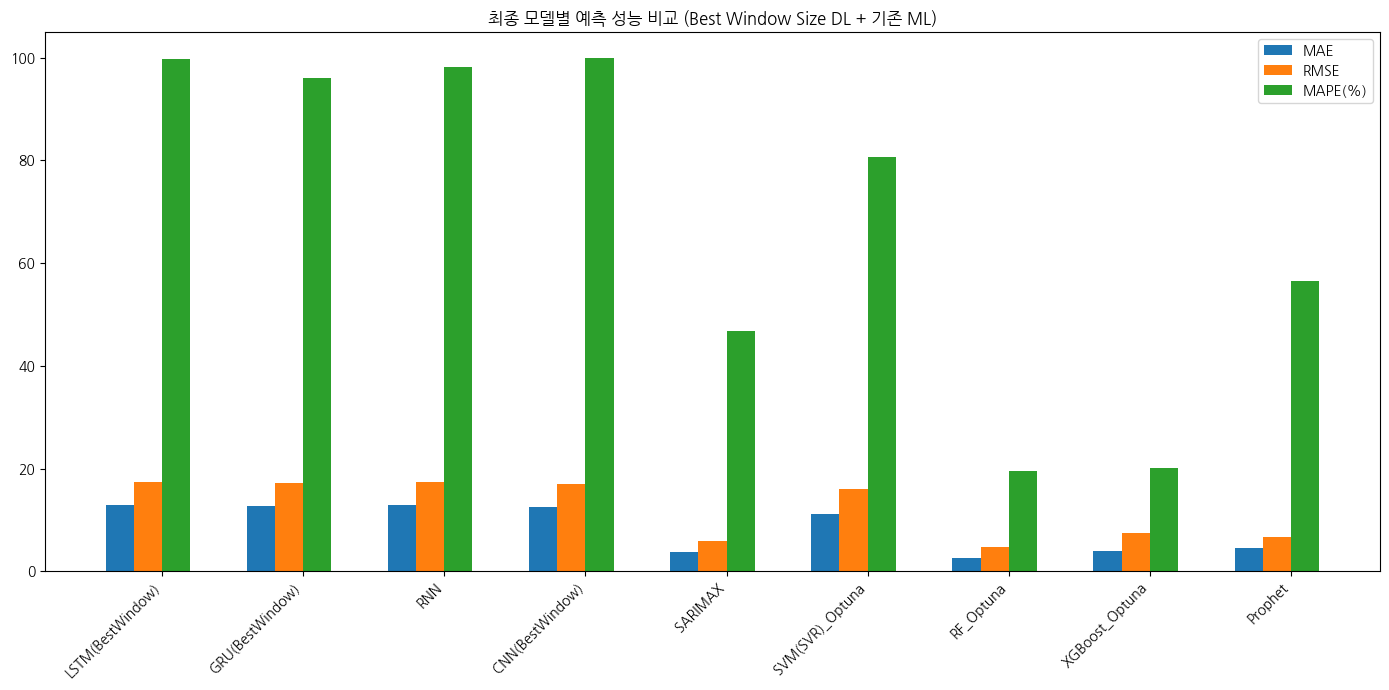


작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.


In [126]:
########################################
# 12. 최종 결과 비교 및 시각화
########################################
# 모델 이름 수정 (Best Window Size DL 모델)
best_lstm_row['Model'] = 'LSTM(BestWindow)'
best_gru_row['Model'] = 'GRU(BestWindow)'
best_cnn_row['Model'] = 'CNN(BestWindow)'
sarimax_result['Model'] = 'SARIMAX'
svr_result_opt['Model'] = 'SVM(SVR)_Optuna'
rf_result_opt['Model'] = 'RF_Optuna'
xgb_result_opt['Model'] = 'XGBoost_Optuna'
prophet_result['Model'] = 'Prophet'

final_results_df_window = pd.DataFrame([
    best_lstm_row.to_dict(),
    best_gru_row.to_dict(),
    best_rnn_row.to_dict(),
    best_cnn_row.to_dict(),
    sarimax_result,
    svr_result_opt,
    rf_result_opt,
    xgb_result_opt,
    prophet_result,

])
final_results_df_window = final_results_df_window[['Model', 'Time Steps', 'Best Params', 'MAE', 'RMSE', 'MAPE']]
final_results_df_window.fillna('-', inplace=True)
print("\n=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===")
display(final_results_df_window)

final_results_df_window.rename(columns={'MAPE': 'MAPE(%)'}, inplace=True)
final_results_df_window['MAPE(%)'] = final_results_df_window['MAPE(%)'] * 100

plt.figure(figsize=(14,7))
bar_x = np.arange(len(final_results_df_window))
plt.bar(bar_x - 0.3, final_results_df_window['MAE'], 0.2, label='MAE')
plt.bar(bar_x - 0.1, final_results_df_window['RMSE'], 0.2, label='RMSE')
plt.bar(bar_x + 0.1, final_results_df_window['MAPE(%)'], 0.2, label='MAPE(%)')
plt.xticks(bar_x, final_results_df_window['Model'], rotation=45, ha='right')
plt.title("최종 모델별 예측 성능 비교 (Best Window Size DL + 기존 ML)")
plt.legend()
plt.tight_layout()
plt.show()

gc.collect()
print("\n작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.")

In [ ]:
def evaluate_prophet_feature_importance(train_df, test_df, extra_regressors):
    # 1. 모든 regressors를 사용한 모델(기준 모델) 성능 평가
    baseline_model, baseline_forecast = train_prophet(train_df, test_df, extra_regressors)
    baseline_pred = baseline_forecast['yhat'].values
    baseline_perf = evaluate_performance(test_df['y'].values, baseline_pred, model_name="Prophet Baseline")

    # baseline_perf가 {'MAE': value, 'RMSE': value, 'MAPE': value, ...} 형태라고 가정합니다.

    importance_results = []
    for reg in extra_regressors:
        # 현재 Feature(reg)를 제외한 나머지 regressors를 사용
        regressors_subset = [r for r in extra_regressors if r != reg]
        model, forecast = train_prophet(train_df, test_df, extra_regressors=regressors_subset)
        pred = forecast['yhat'].values
        perf = evaluate_performance(test_df['y'].values, pred, model_name=f"Prophet without {reg}")

        # 성능 지표 차이 계산 (예: 기준 모델과 비교하여 MAE, RMSE, MAPE가 얼마나 증가 또는 감소했는지)
        # 값이 작아진다면 해당 변수의 제거가 성능 향상에 기여한 것으로 해석할 수 있습니다.
        diff_mae = baseline_perf['MAE'] - perf['MAE']
        diff_rmse = baseline_perf['RMSE'] - perf['RMSE']
        diff_mape = baseline_perf['MAPE'] - perf['MAPE']
        importance_results.append({
            'Dropped Regressor': reg,
            'MAE Diff': diff_mae,
            'RMSE Diff': diff_rmse,
            'MAPE Diff': diff_mape
        })
    return pd.DataFrame(importance_results)

# extra_regressors (feature_cols)를 사용하여 Prophet 모델의 Feature 중요도 평가
importance_df = evaluate_prophet_feature_importance(prophet_train, prophet_test, feature_cols)
print("Extra Regressor 제거에 따른 성능 변화:")
display(importance_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/3r5khvi6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/2wmobgur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64484', 'data', 'file=/tmp/tmp3hsf9dy4/3r5khvi6.json', 'init=/tmp/tmp3hsf9dy4/2wmobgur.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelyku4nchn/prophet_model-20250212074919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/tfl6uj7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/ifsn5_h9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[Prophet Baseline] MAE=0.165, RMSE=0.201, MAPE=0.020


07:49:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/jbl8rdu1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/0m1d7r_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3274', 'data', 'file=/tmp/tmp3hsf9dy4/jbl8rdu1.json', 'init=/tmp/tmp3hsf9dy4/0m1d7r_k.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modeliwlknn8e/prophet_model-20250212074920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without SO2] MAE=0.018, RMSE=0.021, MAPE=0.003


07:49:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/8hpthyqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/fpd6ibwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66981', 'data', 'file=/tmp/tmp3hsf9dy4/8hpthyqq.json', 'init=/tmp/tmp3hsf9dy4/fpd6ibwp.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_model7shmjngn/prophet_model-20250212074921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without CO] MAE=0.144, RMSE=0.174, MAPE=0.018


07:49:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/nzh7tt4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/tq1sqbe_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8147', 'data', 'file=/tmp/tmp3hsf9dy4/nzh7tt4k.json', 'init=/tmp/tmp3hsf9dy4/tq1sqbe_.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelx90gzm_k/prophet_model-20250212074921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without O3] MAE=0.191, RMSE=0.234, MAPE=0.023


07:49:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/uj6mvxu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/6i7kl14x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30112', 'data', 'file=/tmp/tmp3hsf9dy4/uj6mvxu3.json', 'init=/tmp/tmp3hsf9dy4/6i7kl14x.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modeldecumwyx/prophet_model-20250212074921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without NO2] MAE=0.169, RMSE=0.207, MAPE=0.020


07:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/tg8i5l3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/bh0i0n07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45637', 'data', 'file=/tmp/tmp3hsf9dy4/tg8i5l3a.json', 'init=/tmp/tmp3hsf9dy4/bh0i0n07.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelzulydpzu/prophet_model-20250212074923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without 평균기온(℃)] MAE=0.424, RMSE=0.477, MAPE=0.059


07:49:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/eh5zhlih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/crkrz4zz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44834', 'data', 'file=/tmp/tmp3hsf9dy4/eh5zhlih.json', 'init=/tmp/tmp3hsf9dy4/crkrz4zz.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelqyd6badn/prophet_model-20250212074923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without PM25] MAE=0.198, RMSE=0.245, MAPE=0.023


07:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/66mm5myg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/wemj__81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83491', 'data', 'file=/tmp/tmp3hsf9dy4/66mm5myg.json', 'init=/tmp/tmp3hsf9dy4/wemj__81.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelxxrbvdj6/prophet_model-20250212074924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without Traffic] MAE=0.059, RMSE=0.064, MAPE=0.009


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/c2tq_hot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/blnf21qh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40061', 'data', 'file=/tmp/tmp3hsf9dy4/c2tq_hot.json', 'init=/tmp/tmp3hsf9dy4/blnf21qh.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_model5z77vz25/prophet_model-20250212074925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without Cases_lag1] MAE=9.330, RMSE=11.164, MAPE=1.713
[Prophet without Cases_Diff] MAE=4.484, RMSE=6.694, MAPE=0.564
Extra Regressor 제거에 따른 성능 변화:


,Dropped Regressor,MAE Diff,RMSE Diff,MAPE Diff
0,SO2,0.146918,0.180622,0.016685
1,CO,0.020831,0.026961,0.002225
2,O3,-0.025922,-0.032054,-0.003028
3,NO2,-0.003531,-0.006019,-0.000102
4,평균기온(℃),-0.258950,-0.276013,-0.039567
5,PM25,-0.033149,-0.043184,-0.003476
6,Traffic,0.106617,0.137244,0.011257
7,Cases_lag1,-9.165197,-10.962270,-1.693238
8,Cases_Diff,-4.318271,-6.492488,-0.544512


In [ ]:
## 0212 피드백 추가 k-select 방식을 통해 feature를 조사해볼것.